In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
plt.gcf().subplots_adjust(bottom=0.15)

<Figure size 432x288 with 0 Axes>

In [3]:
dataset = pd.read_csv('../data/df_lab__extended_features.csv')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Unnamed: 0                       6040 non-null   int64 
 1   Unnamed: 0.1                     6040 non-null   int64 
 2   Unnamed: 0.1.1                   6040 non-null   int64 
 3   Unnamed: 0.1.1.1                 6040 non-null   int64 
 4   drugName                         6040 non-null   object
 5   condition                        6040 non-null   object
 6   date                             6040 non-null   object
 7   use_case                         6040 non-null   object
 8   sentences                        6040 non-null   object
 9   sentences_length                 6040 non-null   int64 
 10  n_sentences                      6040 non-null   int64 
 11  sents                            6040 non-null   object
 12  doc_id                           6

In [5]:
dataset.drugName.value_counts()

Ethinyl estradiol / norgestimate    2026
Oseltamivir                         1019
Prozac                              1005
Suprep Bowel Prep Kit               1003
Liraglutide                          987
Name: drugName, dtype: int64

In [6]:
dataset.condition.value_counts()

Birth Control        1038
Influenza            1019
Depression           1005
Bowel Preparation    1003
Acne                  988
Diabetes, Type 2      987
Name: condition, dtype: int64

In [7]:

dataset_info = pd.DataFrame.from_dict({f"({use_case.split('::')[0]}; {use_case.split('::')[1]})": [
    len(dataset.query('use_case == @use_case').doc_id.unique()),
    len(dataset.query('use_case == @use_case')),
    #dataset.query('use_case == @use_case').agreed_labels.value_counts().to_dict()['NON_RELATED'],
    #dataset.query('use_case == @use_case').agreed_labels.value_counts().to_dict()['supporting'],
    #dataset.query('use_case == @use_case').agreed_labels.value_counts().to_dict()['attacking']]
]
    for use_case in dataset.use_case.unique()}, orient='index',
    columns=['# docs', '# text_units',
             #'# non_related', '# supporting', '# attacking'
             ]).reset_index().rename(columns={'index': 'use_case'})

dataset_info


,use_case,# docs,# text_units
0,(Suprep-Bowel-Prep-Kit; Bowel-Preparation),110,1003
1,(Ethinyl-estradiol-/-norgestimate; Birth-Control),160,1038
2,"(Liraglutide; Diabetes,-Type-2)",139,987
3,(Ethinyl-estradiol-/-norgestimate; Acne),140,988
4,(Prozac; Depression),159,1005
5,(Oseltamivir; Influenza),150,1019


In [8]:
dataset_info.to_latex('../data/results/dataset_info_1.tex', index=False)


In [9]:

dataset_info_anns = pd.DataFrame.from_dict({f"({use_case.split('::')[0]}; {use_case.split('::')[1]})": [
    #len(dataset.query('use_case == @use_case').doc_id.unique()),
    len(dataset.query('use_case == @use_case')),
    dataset.query('use_case == @use_case').agreed_labels.value_counts().to_dict()['NON_RELATED'],
    dataset.query('use_case == @use_case').agreed_labels.value_counts().to_dict()['supporting'],
    dataset.query('use_case == @use_case').agreed_labels.value_counts().to_dict()['attacking']
] for use_case in dataset.use_case.unique()}, orient='index',
    columns=['# text_units',
             '# non_related', '# supporting', '# attacking'
             ]).reset_index().rename(columns={'index': 'use_case'})

dataset_info_anns


,use_case,# text_units,# non_related,# supporting,# attacking
0,(Suprep-Bowel-Prep-Kit; Bowel-Preparation),1003,702,153,148
1,(Ethinyl-estradiol-/-norgestimate; Birth-Control),1038,554,189,295
2,"(Liraglutide; Diabetes,-Type-2)",987,568,255,164
3,(Ethinyl-estradiol-/-norgestimate; Acne),988,576,188,224
4,(Prozac; Depression),1005,645,199,161
5,(Oseltamivir; Influenza),1019,717,165,137


In [10]:
dataset_info_anns_ext = pd.concat([dataset_info_anns,
                                   pd.DataFrame.from_dict({'Total': [dataset_info_anns["# text_units"].sum(),
                                                                     dataset_info_anns["# non_related"].sum(),
                                                                     dataset_info_anns["# supporting"].sum(),
                                                                     dataset_info_anns["# attacking"].sum()]},
                                                          orient='index',
                                                          columns=['# text_units', '# non_related', '# supporting',
                                                                   '# attacking']).reset_index().rename(
                                       columns={'index': 'use_case'})
                                   ])
dataset_info_anns_ext

,use_case,# text_units,# non_related,# supporting,# attacking
0,(Suprep-Bowel-Prep-Kit; Bowel-Preparation),1003,702,153,148
1,(Ethinyl-estradiol-/-norgestimate; Birth-Control),1038,554,189,295
2,"(Liraglutide; Diabetes,-Type-2)",987,568,255,164
3,(Ethinyl-estradiol-/-norgestimate; Acne),988,576,188,224
4,(Prozac; Depression),1005,645,199,161
5,(Oseltamivir; Influenza),1019,717,165,137
0,Total,6040,3762,1149,1129


In [12]:
dataset_info_anns_ext.to_latex('../data/results/annotation_report.tex', index=False)


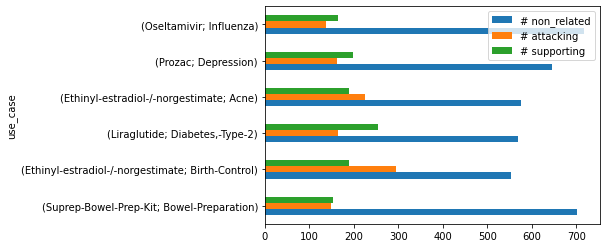

In [11]:
#dataset_info_anns.plot(x='use_case', y=['# non_related', '# attacking', '# supporting'], style='*')
ax = dataset_info_anns.set_index('use_case').plot.barh(y=['# non_related', '# attacking', '# supporting'], rot=0, stacked=False)
fig = ax.get_figure()
fig.savefig('counted_labels.png', bbox_inches="tight", dpi=300)

In [9]:
dataset.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,drugName,condition,date,use_case,sentences,sentences_length,...,feat_synt_and_indic,feat_freq_unigrams,feat_freq_dep_tupl,merged_features,metamap_feats,w2v_400,merged_features_with_embeddings,pos_repr,feat_pos_rep,merged_features_extended
0,0,0,0,3036,Suprep Bowel Prep Kit,Bowel Preparation,"June 12, 2014",Suprep-Bowel-Prep-Kit::Bowel-Preparation,"39 year old male, 1st colonoscopy.",34,...,[0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 3...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.204517 0.050652 -0.137260 0.164892 -0.14...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","CD NN JJ NN , JJ NN .","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,1,1,1,3037,Suprep Bowel Prep Kit,Bowel Preparation,"June 12, 2014",Suprep-Bowel-Prep-Kit::Bowel-Preparation,I had already read several of the reviews of t...,95,...,[0 0 0 0 0 1 0 0 0 1 0 2 0 0 0 2 1 0 0 0 0 0 1...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 0.123579 0.050135 -0.006912 -0.107060 0.01...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, ...",PRP VBD RB VBN JJ IN DT NNS IN DT NN CC VBD RB...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, ..."
2,2,2,2,3038,Suprep Bowel Prep Kit,Bowel Preparation,"June 12, 2014",Suprep-Bowel-Prep-Kit::Bowel-Preparation,Started 1st dose at 6pm night before procedur...,96,...,[0 0 0 0 0 1 0 0 0 1 2 1 0 0 0 3 0 0 0 0 0 0 6...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 0.042712 -0.008658 -0.208361 -0.036315 0.22...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, ...",_SP VBD NN VB IN CD NN NN IN NN CC NNS VBD VBG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, ..."
3,3,3,3,3039,Suprep Bowel Prep Kit,Bowel Preparation,"June 12, 2014",Suprep-Bowel-Prep-Kit::Bowel-Preparation,"No cramping, pain or discomfort whatsoever.",43,...,[0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 3...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 0.092122 0.135516 -0.036986 0.186957 -0.14...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","DT NN , NN CC NN RB .","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
4,4,4,4,3040,Suprep Bowel Prep Kit,Bowel Preparation,"June 12, 2014",Suprep-Bowel-Prep-Kit::Bowel-Preparation,Took the second dose at midnight with similar ...,54,...,[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 2 2 0 0 0 0 0 2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.005430 -0.179298 0.091927 0.050085 0.25...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",VBD DT JJ NN IN NN IN JJ NNS .,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


### Agreement

In [52]:
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

In [56]:

le.fit(['NON_RELATED', 'supporting', 'attacking'])

labeler1 = le.transform(dataset.ann_user_1)
labeler2 = le.transform(dataset.ann_user_2)
labeler3 = le.transform(dataset.ann_user_3)

label_1_2 = cohen_kappa_score(labeler1, labeler2)
label_1_3 = cohen_kappa_score(labeler1, labeler3)
label_2_3 = cohen_kappa_score(labeler2, labeler3)

In [70]:
agreement = pd.DataFrame.from_dict(
    {'Annotators 1-2': label_1_2, 'Annotators 1-3': label_1_3, 'Annotators 2-3': label_2_3}, orient='index',
    columns=['Kappa']).reset_index().rename(columns={'index': ' ', '0': 'Kappa'})

In [80]:
agree_table = pd.concat([agreement, pd.DataFrame.from_dict({'Average': agreement.Kappa.mean()}, orient='index',
                                                           columns=['Kappa']).reset_index().rename(
    columns={'index': ' '})])
agree_table

,,Kappa
0,Annotators 1-2,0.720270
1,Annotators 1-3,0.721038
2,Annotators 2-3,0.717789
0,Average,0.719699


In [81]:
agree_table.to_latex('../data/results/agree_table.tex', index=False)

In [83]:
dataset.agreement.value_counts()

total      4676
partial    1328
none         36
Name: agreement, dtype: int64

In [85]:
dataset.query('agreement == "none"')

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,drugName,condition,date,use_case,sentences,sentences_length,...,feat_synt_and_indic,feat_freq_unigrams,feat_freq_dep_tupl,merged_features,metamap_feats,w2v_400,merged_features_with_embeddings,pos_repr,feat_pos_rep,merged_features_extended
175,175,175,175,3211,Suprep Bowel Prep Kit,Bowel Preparation,"September 21, 2012",Suprep-Bowel-Prep-Kit::Bowel-Preparation,I only drank half of it 6 pm night before - co...,304,...,[ 0 0 0 0 0 1 5 0 0 1 4 4 0 0 2 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 1, 5, 0, 0, 1, 4, 4, 0, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.077275 -0.429988 0.079353 0.037125 -0.03...,"[0, 0, 0, 0, 0, 1, 5, 0, 0, 1, 4, 4, 0, 0, 2, ...",PRP RB VBD NN IN PRP CD NN NN RB : MD RB VB VB...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 5, 0, 0, 1, 4, 4, 0, 0, 2, ..."
539,543,543,543,3579,Suprep Bowel Prep Kit,Bowel Preparation,"April 7, 2016",Suprep-Bowel-Prep-Kit::Bowel-Preparation,"It's unpleasant, but not impossible.",36,...,[0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 0.183028 0.435850 0.245247 0.056021 -0.22...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","PRP VBZ JJ , CC RB JJ .","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
588,592,592,592,3628,Suprep Bowel Prep Kit,Bowel Preparation,"November 4, 2016",Suprep-Bowel-Prep-Kit::Bowel-Preparation,It works but it's awful,23,...,[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 0.042577 0.083054 0.189770 0.063923 -0.10...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",PRP VBZ CC PRP VBZ JJ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
847,853,853,853,3889,Suprep Bowel Prep Kit,Bowel Preparation,"August 30, 2015",Suprep-Bowel-Prep-Kit::Bowel-Preparation,"\r\n\r\nTwo hours later, light cramping and fa...",62,...,[0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 4...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",[-0.012467 -0.247589 0.325754 -0.227849 -0.08...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","_SP CD NNS RB , NN NN CC JJ NN NN .","[0.0, 0.2712079731566047, 0.31195516537994683,...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
1056,1065,1065,1065,4101,Ethinyl estradiol / norgestimate,Birth Control,"September 1, 2016",Ethinyl-estradiol-/-norgestimate::Birth-Control,"The acne is mild to low, but has only gotten w...",84,...,[0 0 2 0 0 1 0 0 0 1 0 1 0 0 0 2 2 2 0 0 0 0 1...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 0.058281 0.044989 0.034719 -0.009265 -0.03...,"[0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","DT NN VBZ JJ IN JJ , CC VBZ RB VBN JJR IN PRP ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
1103,1112,1112,1112,4148,Ethinyl estradiol / norgestimate,Birth Control,"April 14, 2013",Ethinyl-estradiol-/-norgestimate::Birth-Control,"Overall, it did its job, helped with my acne (...",132,...,[0 0 4 1 1 1 0 0 0 3 0 1 0 0 0 2 2 0 0 0 0 0 4...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [86]:
len(dataset.query('agreement == "none"')) / len(dataset)

0.005960264900662252